In [1]:
from os import listdir
from os.path import join
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
import torch.nn as nn

from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from tqdm.notebook import tqdm

## Define Dataset and DataLoader

In [2]:
class SegmentedImageDataset(Dataset):
    def __init__(self, image_dir: str, segmented_dir: str, metadata_path: str, image_transforms: Optional[v2.Compose], mask_transforms: Optional[v2.Compose], unified_transforms: Optional[v2.Compose]):
        metadata_df = pl.read_csv(metadata_path).with_columns(file_key=pl.col('FileName_OrigRNA').str.split('-').list.first().str.reverse().str.slice(3).str.reverse())

        self.metadata_dict = metadata_df.select('file_key', 'Metadata_pert_iname').to_pandas().set_index('file_key')['Metadata_pert_iname'].to_dict()
        self.target_dict = {tgt: torch.tensor(i, dtype=torch.int64) for i, tgt in enumerate(metadata_df.get_column('Metadata_pert_iname').unique())}
        
        self.image_dir = image_dir
        self.images = listdir(image_dir)
        self.segmented_dir = segmented_dir
        
        assert len(self.images) == len(listdir(segmented_dir))
        self.length = len(self.images)
        
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.unified_transforms = unified_transforms
        
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        img_file_name = self.images[index]
        img = Image.open(join(self.image_dir, img_file_name))
        img = img if self.image_transforms is None else self.image_transforms(img)
        
        seg = torch.tensor(np.load(join(self.segmented_dir, img_file_name + '.npy')).astype('int64')).unsqueeze(0)
        seg = seg if self.mask_transforms is None else self.mask_transforms(seg)
        
        out = torch.cat((seg, img))
        out = out if self.unified_transforms is None else self.unified_transforms(out)
        
        target = self.target_dict[self.metadata_dict[img_file_name.split('_')[0]]]
        
        return out, target
        
    def __len__(self) -> int:
        return self.length
    
    def n_classes(self) -> int:
        return len(self.target_dict)

In [3]:
BATCH_SIZE = 128

rng = torch.random.manual_seed(77)
dataset = SegmentedImageDataset(
    'Data/downsampled_data', 
    'Segmented', 
    'Data/metadata_BR00116991.csv', 
    v2.Compose([
        v2.ToImage(),
        v2.RandomVerticalFlip(),
        v2.RandomHorizontalFlip(),
        v2.RandomRotation(degrees=20),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    None,
    v2.Compose([
        v2.RandomResizedCrop(128)
    ])
)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=rng)
train_loader, test_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True), DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Make sure everything is working properly

Example Mask


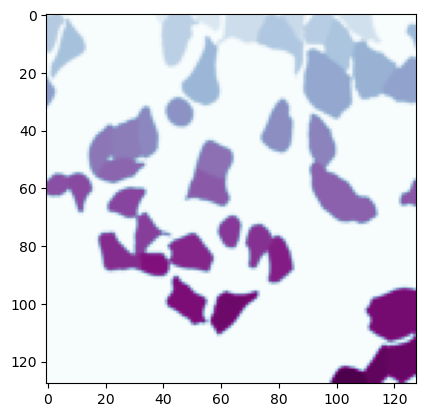

Example Image


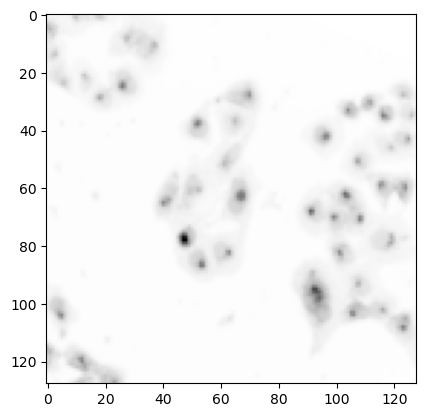

Example Masked Image


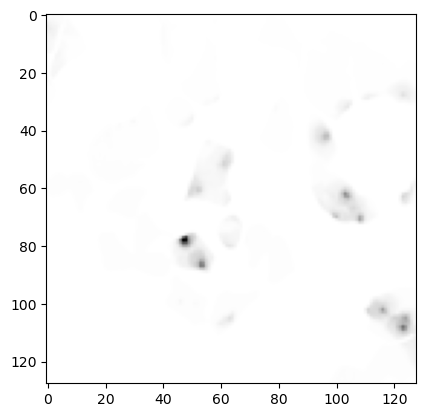

In [4]:
samp = next(iter(train_loader))[0][0]

_ = plt.imshow(samp[0], cmap='BuPu')
print('Example Mask')
plt.show()

_ = plt.imshow(samp[1], cmap='Grays')
print('Example Image')
plt.show()

plt.imshow(samp[0] * samp[1], cmap='Grays')
print('Example Masked Image')
plt.show()

## Define the Training and Test Procedures

In [5]:
def train_loop(device, classifier, train_loader, optimizer, scheduler, loss_fn, n_epochs):
    losses, accs = [], []
    classifier.train()
    iters = len(train_loader)
    for epoch in range(1, 1+n_epochs):
        loss_val = 0
        acc_val = 0
        n = 0
        for i, (X, y) in tqdm(enumerate(train_loader), total=iters):
            m = y.size(0)
    
            X, y = X.to(device), y.to(device)
            yhat = classifier(X)
            pred = torch.argmax(yhat, dim=1)
            
            loss = loss_fn(yhat, y)
            acc = (pred == y).sum()
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            
            loss_val += loss.item() * m
            acc_val += acc.item()
            n += m
        
        print(f'Epoch {epoch}: Loss = {loss_val / n:.3f}; Accuracy = {acc_val / n:.3f}; LR = {scheduler.get_last_lr()[0]}')
        losses.append(loss_val / n)
        accs.append(acc_val / n)
        
    
    return np.array(losses), np.array(accs)


In [6]:
def test_loop(device, classifier, test_loader, loss_fn) -> Tuple[float, float]:
    classifier.eval()
    loss_val = 0
    acc_val = 0
    n = 0
    with torch.no_grad():
        for (X, y) in tqdm(test_loader):
            m = y.size(0)
    
            X, y = X.to(device), y.to(device)
            yhat = classifier(X)
            pred = torch.argmax(yhat, dim=1)
            
            loss = loss_fn(yhat, y)
            acc = (pred == y).sum()
                       
            loss_val += loss.item() * m
            acc_val += acc.item()
            n += m
    
    return loss_val / n, acc_val / n


## Fit the model

### Old

In [10]:
class MaskGuidedAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x, mask):
        mask_attention = self.attention_conv(mask)
        return x * mask_attention

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.image_features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )
        
        self.mask_features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )
        
        self.attention = MaskGuidedAttention(128)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        mask, image = x[:, :1], x[:, 1:]  # mask is channel 0, image is channel 1
        
        image_features = self.image_features(image)
        mask_features = self.mask_features(mask)
        
        attention_features = self.attention(image_features, mask_features)
        
        image_vector = self.gap(attention_features).flatten(1)
        mask_vector = self.gap(mask_features).flatten(1)
        
        comb_vector = torch.cat([image_vector, mask_vector], dim=1)
        
        return self.classifier(comb_vector)

In [11]:
class ClassifierV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.image_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.image_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.image_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.mask_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.mask_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.mask_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.attention1 = MaskGuidedAttention(32)
        self.attention2 = MaskGuidedAttention(64)
        self.attention3 = MaskGuidedAttention(128)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        image, mask = x[:, 1:], x[:, :1]
        
        image_features1 = self.image_block1(image)
        mask_features1 = self.mask_block1(mask)
        image_features1 = self.attention1(image_features1, mask_features1)
        
        image_features2 = self.image_block2(image_features1)
        mask_features2 = self.mask_block2(mask_features1)
        image_features2 = self.attention2(image_features2, mask_features2)
        
        image_features3 = self.image_block3(image_features2)
        mask_features3 = self.mask_block3(mask_features2)
        image_features3 = self.attention3(image_features3, mask_features3)
        
        image_vector = self.gap(image_features3).flatten(1)
        mask_vector = self.gap(mask_features3).flatten(1)
        
        comb_vector = torch.cat([image_vector, mask_vector], dim=1)
        
        return self.classifier(comb_vector)

In [12]:
device = torch.device('mps')

clf = Classifier(dataset.n_classes()).to(device)

optim = torch.optim.Adam(clf.parameters(), lr=5e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=5e-3, epochs=200, steps_per_epoch=len(train_loader))
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

for model_num in range(20):
    losses, accs = train_loop(device, clf, train_loader, optim, scheduler, loss_fn, 10)
    test_loss, test_acc = test_loop(device, clf, test_loader, loss_fn)
    print(f'Test Loss: {test_loss:.3f}; Test Accuracy: {test_acc:.3f}')
    torch.save(clf.state_dict(), f'final_clf_{model_num}.pth')

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 5.622; Accuracy = 0.109; LR = 0.000203295214619645


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 5.433; Accuracy = 0.177; LR = 0.00021317180977909085


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 5.293; Accuracy = 0.177; LR = 0.00022960266422770298


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 5.218; Accuracy = 0.177; LR = 0.00025254265863898593


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 5.167; Accuracy = 0.177; LR = 0.0002819287995088097


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 5.124; Accuracy = 0.177; LR = 0.0003176803921363311


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 5.091; Accuracy = 0.177; LR = 0.00035969926221263247


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 5.048; Accuracy = 0.177; LR = 0.0004078700254085679


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 5.013; Accuracy = 0.177; LR = 0.00046206040422153496


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 4.985; Accuracy = 0.178; LR = 0.0005221215912111082


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.995; Test Accuracy: 0.187


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 4.950; Accuracy = 0.179; LR = 0.000587888657626089


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 4.918; Accuracy = 0.178; LR = 0.0006591810063008565


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 4.889; Accuracy = 0.180; LR = 0.0007358028675773952


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 4.863; Accuracy = 0.184; LR = 0.0008175438368911497


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 4.845; Accuracy = 0.183; LR = 0.000904179452544532


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 4.815; Accuracy = 0.185; LR = 0.0009954718120814745


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 4.768; Accuracy = 0.188; LR = 0.0010911702255704692


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 4.702; Accuracy = 0.185; LR = 0.0011910119040021783


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 4.649; Accuracy = 0.188; LR = 0.0012947226809112526


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 4.601; Accuracy = 0.192; LR = 0.001402017765240788


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 5.013; Test Accuracy: 0.178


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 4.571; Accuracy = 0.189; LR = 0.001512602523382036


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 4.538; Accuracy = 0.193; LR = 0.0016261732882418812


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 4.486; Accuracy = 0.194; LR = 0.001742418193116383


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 4.472; Accuracy = 0.195; LR = 0.0018610180280805382


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 4.416; Accuracy = 0.201; LR = 0.0019816471165426297


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 4.415; Accuracy = 0.200; LR = 0.002103974209556113


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 4.382; Accuracy = 0.203; LR = 0.0022276633954332547


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 4.414; Accuracy = 0.203; LR = 0.002352375022162729


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 4.370; Accuracy = 0.199; LR = 0.0024777666300981687


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 4.372; Accuracy = 0.199; LR = 0.002603493892356532


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.785; Test Accuracy: 0.178


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 4.336; Accuracy = 0.208; LR = 0.002729211560343919


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 4.325; Accuracy = 0.209; LR = 0.002854574411812412


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 4.268; Accuracy = 0.212; LR = 0.0029792381988445783


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 4.271; Accuracy = 0.214; LR = 0.003102860593162444


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 4.227; Accuracy = 0.214; LR = 0.003225102126165115


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 4.246; Accuracy = 0.207; LR = 0.003345627121113695


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 4.217; Accuracy = 0.213; LR = 0.003464104614903692


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 4.186; Accuracy = 0.218; LR = 0.0035802092668937445


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 4.171; Accuracy = 0.218; LR = 0.0036936222522949798


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 4.149; Accuracy = 0.220; LR = 0.0038040321376677706


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.476; Test Accuracy: 0.211


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 4.154; Accuracy = 0.219; LR = 0.003911135736121759


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 4.155; Accuracy = 0.226; LR = 0.004014638939870737


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 4.118; Accuracy = 0.224; LR = 0.0041142575278562315


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 4.091; Accuracy = 0.230; LR = 0.004209717946221975


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 4.107; Accuracy = 0.220; LR = 0.004300758059496139


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 4.093; Accuracy = 0.224; LR = 0.004387127870418526


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 4.079; Accuracy = 0.226; LR = 0.004468590206436095


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 4.083; Accuracy = 0.225; LR = 0.004544921370981687


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 4.037; Accuracy = 0.239; LR = 0.00461591175774751


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 4.121; Accuracy = 0.230; LR = 0.004681366426266631


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 5.569; Test Accuracy: 0.154


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 4.043; Accuracy = 0.233; LR = 0.004741105637221856


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 4.029; Accuracy = 0.240; LR = 0.0047949653460120974


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 4.023; Accuracy = 0.244; LR = 0.004842797653220844


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 4.027; Accuracy = 0.236; LR = 0.004884471210749756


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.985; Accuracy = 0.232; LR = 0.00491987158250215


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.945; Accuracy = 0.244; LR = 0.00494890155862591


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.923; Accuracy = 0.247; LR = 0.004971481422452925


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.911; Accuracy = 0.249; LR = 0.004987549169402035


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.893; Accuracy = 0.246; LR = 0.004997060677244366


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.867; Accuracy = 0.252; LR = 0.004999998057294886


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 24.525; Test Accuracy: 0.007


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.862; Accuracy = 0.254; LR = 0.004999298716152225


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.869; Accuracy = 0.262; LR = 0.004997340907874936


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.850; Accuracy = 0.263; LR = 0.0049941256182784435


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.853; Accuracy = 0.251; LR = 0.0049896544663578886


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.795; Accuracy = 0.264; LR = 0.0049839297034729125


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.797; Accuracy = 0.267; LR = 0.004976954212214028


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.814; Accuracy = 0.266; LR = 0.004968731504951152


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.799; Accuracy = 0.264; LR = 0.004959265722065017


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.754; Accuracy = 0.270; LR = 0.004948561629862369


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.758; Accuracy = 0.274; LR = 0.004936624618175985


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.660; Test Accuracy: 0.201


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.764; Accuracy = 0.266; LR = 0.004923460697650731


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.743; Accuracy = 0.281; LR = 0.004909076496717025


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.702; Accuracy = 0.273; LR = 0.004893479258253217


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.740; Accuracy = 0.275; LR = 0.004876676835938582


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.721; Accuracy = 0.274; LR = 0.004858677690298762


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.677; Accuracy = 0.284; LR = 0.00483949088444563


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.659; Accuracy = 0.285; LR = 0.004819126079513743


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.693; Accuracy = 0.276; LR = 0.004797593529795671


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.722; Accuracy = 0.277; LR = 0.004774904077578649


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.647; Accuracy = 0.296; LR = 0.004751069147685161


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 5.105; Test Accuracy: 0.202


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.661; Accuracy = 0.283; LR = 0.004726100741720198


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.626; Accuracy = 0.293; LR = 0.004700011432028084


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.664; Accuracy = 0.287; LR = 0.00467281435536193


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.653; Accuracy = 0.291; LR = 0.004644523206268876


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.653; Accuracy = 0.288; LR = 0.00461515223019448


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.544; Accuracy = 0.292; LR = 0.004584716216309699


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.582; Accuracy = 0.296; LR = 0.004553230490064108


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.571; Accuracy = 0.300; LR = 0.00452071090546906


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.555; Accuracy = 0.303; LR = 0.004487173837114727


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.532; Accuracy = 0.307; LR = 0.004452636171924995


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 20.708; Test Accuracy: 0.007


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.536; Accuracy = 0.312; LR = 0.004417115300654387


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.556; Accuracy = 0.299; LR = 0.004380629109131298


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.561; Accuracy = 0.303; LR = 0.004343195969251942


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.531; Accuracy = 0.310; LR = 0.004304834729729546


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.541; Accuracy = 0.306; LR = 0.004265564706603459


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.552; Accuracy = 0.323; LR = 0.00422540567351294


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.506; Accuracy = 0.318; LR = 0.00418437785174054


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.506; Accuracy = 0.298; LR = 0.004142501900030071


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.474; Accuracy = 0.316; LR = 0.004099798904184317


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.505; Accuracy = 0.316; LR = 0.004056290366447683


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 7.847; Test Accuracy: 0.061


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.483; Accuracy = 0.314; LR = 0.00401199819467918


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.499; Accuracy = 0.313; LR = 0.003966944691321151


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.508; Accuracy = 0.313; LR = 0.003921152542169324


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.486; Accuracy = 0.320; LR = 0.0038746448049498255


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.464; Accuracy = 0.327; LR = 0.003827444897708925


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.450; Accuracy = 0.323; LR = 0.0037795765870213445


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.460; Accuracy = 0.317; LR = 0.0037310639760230672


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.461; Accuracy = 0.322; LR = 0.003681931492274688


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.409; Accuracy = 0.328; LR = 0.0036322038754613983


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.404; Accuracy = 0.336; LR = 0.00358190616493581


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 5.862; Test Accuracy: 0.072


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.442; Accuracy = 0.326; LR = 0.003531063687109888


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.414; Accuracy = 0.333; LR = 0.003479702042702338


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.372; Accuracy = 0.333; LR = 0.003427847093847874


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.398; Accuracy = 0.337; LR = 0.003375524951074856


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.416; Accuracy = 0.327; LR = 0.003322761960157851


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.383; Accuracy = 0.340; LR = 0.0032695846888517416


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.368; Accuracy = 0.339; LR = 0.0032160199135140635


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.381; Accuracy = 0.335; LR = 0.003162094605622302


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.348; Accuracy = 0.353; LR = 0.0031078359181929407


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.385; Accuracy = 0.334; LR = 0.0030532711721091


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.272; Test Accuracy: 0.264


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.400; Accuracy = 0.339; LR = 0.002998427842363649


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.380; Accuracy = 0.335; LR = 0.0029433335442247215


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.351; Accuracy = 0.345; LR = 0.0028880160193305933


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.371; Accuracy = 0.324; LR = 0.002832503121720937


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.367; Accuracy = 0.333; LR = 0.002776822803811468


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.395; Accuracy = 0.334; LR = 0.002721003102319065


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.328; Accuracy = 0.347; LR = 0.0026650721241444414


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.342; Accuracy = 0.349; LR = 0.0026090580322194667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.331; Accuracy = 0.344; LR = 0.002552989031326289


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.360; Accuracy = 0.338; LR = 0.002496893353895376


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 18.180; Test Accuracy: 0.012


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.333; Accuracy = 0.355; LR = 0.0024407992457896356


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.306; Accuracy = 0.350; LR = 0.00238473495208177


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.283; Accuracy = 0.359; LR = 0.0023287287028320373


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.263; Accuracy = 0.362; LR = 0.0022728086988735635


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.268; Accuracy = 0.363; LR = 0.002217003097612371


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.297; Accuracy = 0.359; LR = 0.00216133999884928


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.303; Accuracy = 0.343; LR = 0.00210584743063081


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.267; Accuracy = 0.365; LR = 0.0020505533351362192


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.282; Accuracy = 0.353; LR = 0.0019954855546077685


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.235; Accuracy = 0.357; LR = 0.0019406718173313202


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 4.502; Test Accuracy: 0.187


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.255; Accuracy = 0.357; LR = 0.001886139723674306


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.265; Accuracy = 0.357; LR = 0.0018319167321881188


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.258; Accuracy = 0.363; LR = 0.0017780301457818945


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.272; Accuracy = 0.358; LR = 0.001724507097974683


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.220; Accuracy = 0.366; LR = 0.0016713745392329005


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.233; Accuracy = 0.369; LR = 0.0016186592233999595


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.251; Accuracy = 0.356; LR = 0.0015663876942249046


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.243; Accuracy = 0.373; LR = 0.001514586271996831


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.222; Accuracy = 0.371; LR = 0.0014632810402918296


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.238; Accuracy = 0.367; LR = 0.0014124978328391195


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 6.576; Test Accuracy: 0.075


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Loss = 3.204; Accuracy = 0.372; LR = 0.00136226222051299


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Loss = 3.197; Accuracy = 0.374; LR = 0.0013125994984570918


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Loss = 3.201; Accuracy = 0.358; LR = 0.0012635346733475721


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Loss = 3.206; Accuracy = 0.374; LR = 0.001215092450801461


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Loss = 3.215; Accuracy = 0.379; LR = 0.0011672972229366445


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Loss = 3.215; Accuracy = 0.376; LR = 0.0011201730560897079


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Loss = 3.201; Accuracy = 0.371; LR = 0.0010737436786978018


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Loss = 3.217; Accuracy = 0.373; LR = 0.0010280324693506628


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Loss = 3.176; Accuracy = 0.379; LR = 0.0009830624450187899


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Loss = 3.193; Accuracy = 0.381; LR = 0.0009388562494637054


  0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 3.650; Test Accuracy: 0.330


  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 